# Wrangling Data for Predicting Hurricane Impacts
* ### From the World Ocean Database for Ocean water data:
    * Salinity, Temperature, Oxygen, Phosphates, and Silicates
    
* ### From the NOAA HURDAT Archive:
    * Hurricanes, Categories, and Landfall Locations
    
*********

# World Ocean Database

In [1]:
#### This script loads files from NOAA World Ocean Database into a dataframe.

# Import, unzip, and open NOAA World Ocean Database files (Gulf of Mexico relevant files) 
# Then consolidate info into one dataframe

# install wodpy and wikipedia
import pip
pip.main(['install','wodpy'])
pip.main(['install','wikipedia'])

# install requests and Beautiful soup
pip.main(['install','bs4'])
pip.main(['install','requests'])

# import packages
import wikipedia as wp
import urllib
import gzip
import os
from datetime import datetime
from wodpy import wod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# WOD file list for Gulf of Mexico
url_list = (["C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 1/OSDO7208.gz",
         "C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 1/OSDO7209.gz"])
file_paths = []
# unzip files and open into a list of unzipped files
for url in url_list:
    
    file_paths.append(url[:-2] + 'dat')
    
    
    
    
    with gzip.open(url, 'rb') as inF:
        s = inF.read()

    with open(url[:-2] + 'dat' , 'wb') as outF:
        outF.write(s)

In [3]:
# WOD file list for Gulf of Mexico (OSD data only)
url_list = (["http://data.nodc.noaa.gov/woa/WOD/GEOGRAPHIC/OSD/OBS/OSDO7208.gz",
         "http://data.nodc.noaa.gov/woa/WOD/GEOGRAPHIC/OSD/OBS/OSDO7209.gz"])

# unzip files and open into a list of unzipped files
file_paths = []
for url in url_list:
    file_path = 'C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 1/test/' + url.split('/')[-1][:-2] + 'dat' 
    file_paths.append(file_path)
    
    file = urllib.request.urlretrieve(url, url.split('/')[-1])
    
    with gzip.open(file[0], 'rb') as inF:
        s = inF.read()
        
    with open(file_path , 'wb') as outF:
        outF.write(s)

### The files is an iterator containing profiles.  These profiles can be transformed into dataframes containing the data taken by depth as information in columns.  Time and location are stored as dataframe attributes. 

In [4]:
# now create a list of dataframes from WodProfiles from the unzipped files.
df_list = []
for path in file_paths:
    j = 1
    with open(path) as file:
        # check to see if current profile is the last in the file and loop through all profiles in file to append to df list
        while j:
            try:
                df_list.append(wod.WodProfile(file).df())
                
                  
            except:
                j = 0


### Upon examination of the dataframes from the profiles some are empty and void of data.  I will remove these from the list of profile dataframes.

In [5]:
def profile_field_select(df):
    """Takes a profile and returns select parameters from the profile as a pandas Dataframe."""
    dic = {'oxygen':df.loc[0,'oxygen'],'pressure':df.loc[0,'pressure'],'pH':df.loc[0,'pH'],
           'phosphate':df.loc[0,'phosphate'],'salinity':df.loc[0,'salinity'],'silicate':df.loc[0,'silicate'],
           'temperature':df.loc[0,'temperature'],'latitude':df.latitude,'longitude':df.longitude,
           'day':df.day,'month':df.month,'time':df.time,'year':df.year}
    return pd.DataFrame(dic, index=[0])

# next pull relevant information from each profile () and then add into a dataframe of aggregated relevant World Ocean Database data
wod_df = pd.DataFrame(columns=['oxygen','pressure','pH','phosphate','salinity','silicate',
                               'temperature','latitude','longitude','day','month','time','year'])

for df in df_list:
    if not df.empty: #filter out blank dataframes
        wod_df = wod_df.append(profile_field_select(df), ignore_index=True)


In [6]:
# reorganize dataframe to have one column with a datetime object by day.
# Then drop unnecessary time columns and sort by newly created date column
wod_df['date'] = pd.to_datetime(wod_df['year'].astype(str) + '-' + wod_df['month'].astype(str) + '-' + wod_df['day'].astype(str))
wod_df = wod_df.drop(['day','month','year','time'],axis=1).sort_values('date')

# create a new series of a tuple of combined lat and lon data (lat,lon) and delete the lat and lon series from the dataframe.
wod_df['location'] = list(zip(wod_df.latitude, wod_df.longitude))
wod_df = wod_df.drop(axis=1,labels=['latitude','longitude'])
# delete data predating 1960 and drop rows with all NaN values
wod_df = wod_df.loc[wod_df['date'] > '1960-01-01'].dropna(how='all')
wod_df


,oxygen,pH,phosphate,pressure,salinity,silicate,temperature,date,location
821,NaN,NaN,0.058,NaN,36.2600,NaN,22.83,1960-02-06,"(25.75, -80.03)"
16875,NaN,NaN,NaN,NaN,36.4000,NaN,20.72,1960-02-17,"(27.57, -92.92)"
16874,NaN,NaN,NaN,NaN,36.3200,NaN,20.26,1960-02-17,"(27.7, -93.03)"
16873,NaN,NaN,NaN,NaN,36.1700,NaN,19.25,1960-02-17,"(27.83, -93.13)"
16872,NaN,NaN,NaN,NaN,36.2200,NaN,19.16,1960-02-17,"(27.98, -93.25)"
824,NaN,NaN,NaN,NaN,36.5300,NaN,22.62,1960-02-20,"(22.32, -88.28)"
825,NaN,NaN,NaN,NaN,36.5500,NaN,22.70,1960-02-20,"(22.32, -88.7)"
823,NaN,NaN,NaN,NaN,36.5200,NaN,22.62,1960-02-20,"(22.32, -87.87)"
822,NaN,NaN,NaN,NaN,36.5100,NaN,22.77,1960-02-20,"(22.32, -87.47)"
826,NaN,NaN,NaN,NaN,36.5500,NaN,22.88,1960-02-21,"(22.32, -89.12)"


### After looking at the data grouped by date, I decided to round the locations to the nearest degree.  Also, historically accurate data wasn't really available until satellites were used to track them circa 1960.  Thus, I removed any rows with dates predating 1960. 

### The data will also be resampled as a monthly average for each set of data at each latitude and longitude.

### Also, the data is pretty sparse for pH and pressure, so these columns will be dropped as well.

### NaN values were handled by filling them with the average values per location.  Leftover NaN values were then filled with the overall time average values.

In [7]:
# round lat and lon
wod_df.location = [str((np.round(lat),np.round(lon))) for lat, lon in wod_df.location]
# set index for dataframe as the date and location and sort and store in new dataframe
wod_df_loc = wod_df.set_index(['location','date']).sort_index().dropna(how='all')
# now group the date levels by month within the separate locations and drop pH and pressure data
wod_df_loc = wod_df_loc.groupby(['location']+[pd.Grouper(freq='M',level=-1)]).mean()
wod_df_loc = wod_df_loc.drop(axis=1,labels=['pH','pressure'])
# now fill NaN values with the mean per location and fill left over NaNs with overall average over time
wod_df_loc = wod_df_loc.fillna(wod_df_loc.groupby(level='location').mean())
wod_df_loc = wod_df_loc.fillna(method='bfill')
wod_df_loc.info()
wod_df_loc
# assuring that there are no duplicate locations
assert wod_df_loc.groupby('location').count().index.value_counts().max() == 1

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4657 entries, ((20.0, -80.0), 1965-05-31 00:00:00) to ((30.0, -94.0), 2004-07-31 00:00:00)
Data columns (total 5 columns):
oxygen         4657 non-null float64
phosphate      4657 non-null float64
salinity       4657 non-null float64
silicate       4657 non-null float64
temperature    4657 non-null float64
dtypes: float64(5)
memory usage: 209.8+ KB


### After looking at the timestamps per location, most locations are sparse in data points.  I will compile a dataframe by month only losing the location information and treat the gulf of mexico as one big body of water.  
### NaN values will be back filled.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 633 entries, 1960-02-29 to 2012-10-31
Freq: M
Data columns (total 5 columns):
oxygen         633 non-null float64
phosphate      633 non-null float64
salinity       633 non-null float64
silicate       633 non-null float64
temperature    633 non-null float64
dtypes: float64(5)
memory usage: 29.7 KB


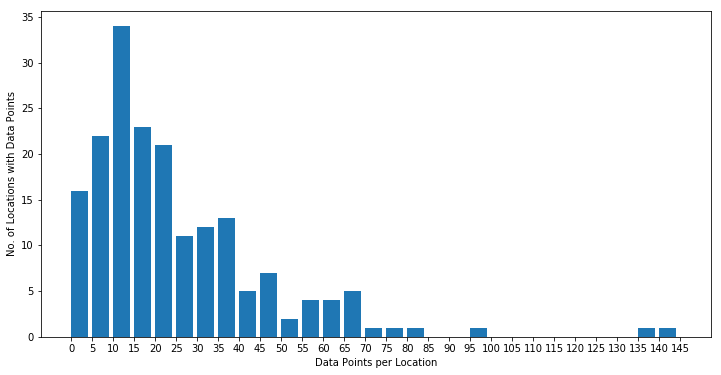

In [8]:
# getting the number of datapoints per location
location_counts = wod_df_loc.groupby('location').count().oxygen

# generating new dataframe based on date alone and sampled Monthly with NaN values bfill
wod_df_date = (wod_df.drop(axis=1,labels=['location']).set_index('date').
                          resample('M').mean().fillna(method='bfill').drop(axis=1,labels=['pressure','pH']))
wod_df_date.info()
wod_df_date

# plot histogram of location data point density
_ = location_counts.plot(kind='hist',bins=list(range(0,150,5)),width=4,figsize=(12,6))
_ = plt.xlabel('Data Points per Location')
_ = plt.xticks(range(0,150,5))
_ = plt.ylabel('No. of Locations with Data Points')
plt.show()

### Basic Exploratory data analysis:
* #### Box plots for each value based from time organized data.
* #### Line plots for each value based from time organized data.
****
### Upon initial visuals it seems the outliers could be real and will not be deleted from the data.
    

           oxygen   phosphate    salinity    silicate  temperature
count  633.000000  633.000000  633.000000  633.000000   633.000000
mean     5.085234    0.521636   33.610917    7.499311    25.116992
std      0.933904    2.551998    4.231965   14.372625     3.588777
min      2.883200    0.000000    5.932903    0.100000    11.147222
25%      4.603000    0.048000   32.466368    1.357143    22.557534
50%      4.866176    0.088889   35.539000    3.500000    25.815000
75%      5.351667    0.230000   35.994211    6.875000    28.115000
max     11.436111   30.999500   36.460000  100.000000    30.715313


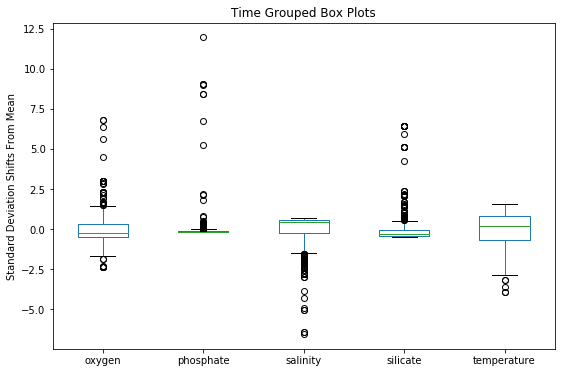

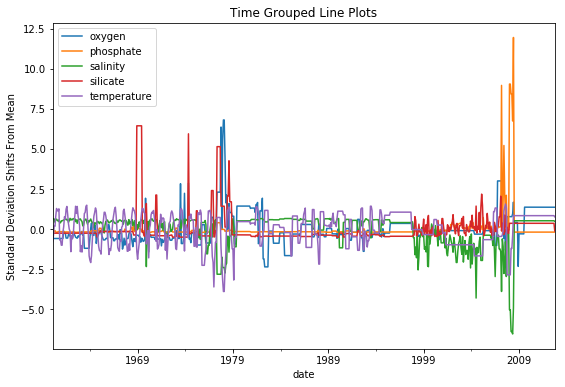

In [9]:
# descriptive summary statistics of data
print(wod_df_date.describe())
# boxplots and lineplots of the std deviation shifts from means
_ = ((wod_df_date - wod_df_date.mean())/wod_df_date.std()).plot(kind='box', figsize=(9,6))
_ = plt.ylabel('Standard Deviation Shifts From Mean')
_ = plt.title('Time Grouped Box Plots')
plt.show()
_ = ((wod_df_date - wod_df_date.mean())/wod_df_date.std()).plot(figsize=(9,6))
_ = plt.ylabel('Standard Deviation Shifts From Mean')
_ = plt.title('Time Grouped Line Plots')
plt.show()


### Later on, the data can be analyzed as by date, by location, or by both to get a wide variety of stories and pictures.

*****

# Historical Hurricane Data for the United States Gulf Coast
### The data comes from the wiki table [List of United States hurricanes](https://en.wikipedia.org/wiki/List_of_United_States_hurricanes).

In [10]:
#Get the html source
html = wp.page("List_of_United_States_hurricanes").html().encode("UTF-8")
#Use pandas built in html reader to bring tables in only for gulf coast states
hurricane_list = [pd.read_html(html,header=0)[i] for i in [1,3,5,9,16]]
state_names = ['Alabama','Florida','Louisiana','Mississippi','Texas']
#last row of tables are footnotes so drop them
hurricanes = [df.drop([len(df.index)-1]) for df in hurricane_list]
#create blank combined dataframe
hurricanes_df = pd.DataFrame(columns=['name','category','state'])

for state, hurricane in zip(state_names,hurricanes):
    #separate the tables and reconcatenate vertically instead of horizontally
    a = hurricane.iloc[:,:4]
    b = hurricane.iloc[:,5:9]
    b.columns = [str(name).split('.')[0] for name in hurricane.columns.values][5:9]
    hurricane = pd.concat([a,b], ignore_index=True)
    
    #remove blank rows from newly concatenated dataframe
    hurricane = hurricane.dropna(how='all').reset_index(drop=True)


    #the date is seperated into two columns so bring together and store as a datetime object
    hurricane['date'] = [datetime.strptime(str(hurricane['Date of closest approach'][i]) + ' ' + 
                                                   str(hurricane['Year'][i])[:4],'%B %d %Y') 
                         for i in range(0,len(hurricane.index))] 
    
    #drop the redundant date columns
    hurricane = hurricane.drop(labels=['Date of closest approach','Year'],axis=1)

    #remove the 'notes' from the category column and rename it to category
    hurricane.columns = ['name','category','date']
    hurricane.category = [str(cat)[0] for cat in hurricane.category]
    
    #find special cases in quotes for name and set to unnamed
    for index, name in enumerate(hurricane.name):
        if '"' in name:
            hurricane.name[index] = 'Unnamed'
            
            

    #set date as index and sort by index
    hurricane = hurricane.set_index('date').sort_index()
    
    #create a state label for the dataframe
    hurricane['state'] = state
    
    #absorb dataframe into combined dataframe for historical hurricane dataframe
    hurricanes_df = hurricanes_df.append(hurricane)

#to keep the times consistent with the WOD database remove dates before 1960
hurricanes_df = hurricanes_df.loc['1960-01-01':,:].sort_index()

hurricanes_df.info()
hurricanes_df.head(20)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86 entries, 1960-09-10 to 2017-10-08
Data columns (total 3 columns):
name        86 non-null object
category    86 non-null object
state       86 non-null object
dtypes: object(3)
memory usage: 2.7+ KB


C:\Users\sethh\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,category,state
1960-09-10,Donna,4,Florida
1960-09-15,Ethel,1,Mississippi
1961-09-11,Carla,4,Texas
1963-09-17,Cindy,1,Texas
1964-08-27,Cleo,2,Florida
1964-09-10,Dora,2,Florida
1964-09-15,Ethel,1,Louisiana
1964-10-03,Hilda,3,Louisiana
1964-10-14,Isbell,2,Florida
1965-09-08,Betsy,3,Florida
